In [144]:
# ----- Disse packages skal bruges til køre notebooken! -----
import numpy as np
np.random.seed(seed=42)
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, norm
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [145]:
# ----- Her defineret path to file for de udleverede datasæt! -----
ptf_Opgave2 = 'Opgave2_DataScientistKoncernIT.csv' # !! Erstat med gyldig path !!
pft_Opgave3 = 'Opgave3_DataScientistKoncernIT.csv' # !! Erstat med gyldig path !!
ptf_Opgave4_1 = 'Opgave4_1_DataScientistKoncernIT.csv' # !! Erstat med gyldig path !!
prf_Opgave4_2 = 'Opgave4_2_DataScientistKoncernIT.csv' # !! Erstat med gyldig path !!

# Opgave 1

### 1.1 - Hvilken fordel har median over gennemsnit?

#### Svar: 

Medianen er mere robust overfor ekstreme målepunkter ("outliers"), der eventuelt kunne skyldes målefejl.

Dette er illusteret ved at generere en lang liste tilfældige tal mellem 1 og 100 og dernæst tilføje 1% potentielle outliers. Grundet det høje talværdier bliver gennemsnitten påvirket, hvor medianen er mere stabil.

In [146]:
list1 = np.random.randint(1, 100, size=(10000,1))
list2 = np.random.randint(1, 10000, size=(100, 1))
list3 = np.concatenate([list1, list2])

In [147]:
print(f"List 1 average: {np.average(list1)}")
print(f"List 1 median: {np.median(list1)}")
print(f"List 3 average: {np.average(list3)}")
print(f"List 3 median: {np.median(list3)}")

List 1 average: 49.876
List 1 median: 50.0
List 3 average: 97.19227722772277
List 3 median: 50.0


### 1.2 - Hvorfor siger man ofte at et neuralt netværk i ML er en "black box"? Hvorfor? Kan du give et eksempel på en ML algoritme som ikke er "black box", og hvorfor den ikke er det?

#### Svar: 

Grunden til at et neuralt netværk uformelt bliver beskrevet som en "black box" er grundlæggende at der ikke tilsyneladende er en logisk eller forklarbar grund til dets beslutninger. Det arbejder med en repræsentation af data der eksisterer i et arbitrært højt dimensionelt rum og det samme gør dens beslutningsgrænse ("decision boundary"). Dette bliver yderligere forstærket af en generel tilfredshed ved blot at vide, hvor godt et neuralt netværk løser en given opgave, og ikke hvordan. Der findes en række metoder og værktøjer til at analysere hvordan ens netværk tager beslutninger, man kan vurdere feature importance, kigge på filtrene i ens CNN, bare for at nævne et par stykker.

Det åbenlyse eksempel på en ML agoritme som ikke er en "black box" er en Random Forest (RF) algoritme. Hvilket er en samling af decision trees. Decision trees laver simple over/under beslutninger ("cuts") på variabler. Alle disse beslutninger taget i hvert eneste træ kan for hvert eneste eksempel følges og anskueliggøres. Man vil altså til hver en tid kunne give en konkret bud på, hvorfor algoritmen har taget en given beslutning.

### 1.3 - Du har fået en almindelig klassificerings opgave af en kunde med noget data og tilhørende label værdier, som du på fremtidig data skal kunne forudsige. Det er dog vigtigt for kunden at algoritmen er ret præcis, og din færdigtrænede algoritme rammer ikke helt den forventede præcision. Kunden vil derfor acceptere at algoritmen kun laver forudsigelser på nogle datapunkter, og springer andre over, for til gengæld at præcisionen øges på de forudsigelser der bliver lavet. Hvordan kan dette løses?

#### Svar:

Det kan løses på mange forskellige måder og den bedste løsning vil højst sandsygligt afhænge af problemstillingen og data. Min umiddelbare indskyldelse er at undersøge hvordan præcisionen af algoritmen afhænger af forskellige variabler. Formålet skulle være at finde et afgrænset område, hvor præcisionen er tilstrækkelig. Jeg kan bedste beskrive fremgangsmåden ved at introducere et eksempel.

Det kan være at man er partikelfysiker og arbejder med klassifikation af partikler i ATLAS detektoren. Detektoren indeholder forskellige regioner, som alle modtager forskellige mændger partikler og måler med varierende præcision. Præcisionen af algoritmen vil derfor afhænge meget af hvilken region af detektoren dataen kommer fra og er kunden i opgaven fysikere fra ATLAS eksperimentet, vil man kunne opnå den ønskede effekt ved at begrænse ens model til bestemte regioner af detektoren.

Præcisionen af ens algoritme er næsten altid højest der, hvor der er mest data. Det er derfor næsten altid muligt at implementere sin model således at det kun kigger på de mest typpiske tilfælde, men hvorvidt det altid er muligt at isolere disse ved en simpel sortering er ikke sikkert. Det kunne f.eks. være en del mere besværligt, hvis man har med billeddata at gøre.

En anden meget oplagt måde at implementere noget der minder om den ønskede løsning af at lade algoritme forudsige på alle datapunkter (normalt er forudsigelsestiden lav), men kun tage de forudsigelser algoritmen giver en meget høj score (>0.99 eller lign.) og give resten af datapunkterne videre til personalet. Denne score kan vælges efter en ønsket TPR/FPR niveau ved brug af en ROC-curve.

### 1.4 - Din virksomhed har taget noget nyt software i brug som efter sigende skulle effektivisere arbejdstiden på typiske opgaver. Du er blevet bedt om at undersøge om den nye software har haft en effekt på arbejdstiden. Du er givet 2 datasæt som hver bare er en liste af total tid brugt på at løse opgaver. Den ene indeholder tider fra før den nye software blev taget i brug og den anden fra efter.
### Du beslutter dig for at bruge en t-test. Hvilke antagelser har du lavet om data?
### Vi antager herfra at softwaren HAR en positiv effekt på arbejdstiden, spørgsmålet er bare om vi kan vise dette ud fra de 2 datasæt:
### Bliver det nemmere eller sværere at vise signifikant forskel mellem de to sæt hvis:
### A) Antallet af samples i hvert sæt øges?
### B) Den interne varians i hvert sæt øges?
### C) De respektive gennemsnitsværdier i hvert datasæt ligger længere fra hinanden?
### Hvad betyder p-værdien i en t-test?

#### Svar:

Den grundlæggende antalgelse der gøres ved brug af en t-test er at man måler på udafhængige normalfordelte distrubitioner, men grundet manglende statistik er spredning (variansen) på disse fordelinger ukendte og må antages ud fra data. Målingerne i en given distribution antages altså at være i.i.d. Ønsker man bruge en helt almindelig t-test antager man desunden at variansen af de to distributioner er ens. Denne antagelse er umiddelbart okay, da det er tale om de samme ansatte, dog vil nyt software uden tvivl kræve en tilvænningsfase med varierende længde!

De næste 3 punkter er besvares ved brug af eksempler nedenfor!

P-værdien i en t-test vurderer den statistiske signifikans af null-hypotesen om at fordelingenernes middelværdi er ens. P-værdien er altså en vurdering af, hvor sandsynligt det er, at hypotesen er sand. Værdier under en given grænse (gerne <0.01, <0.05, eller <0.1) indikerer altså at null hypotesen skal forkastes og at middelværdierne er forskellige.

Ttest_indResult(statistic=2.1543827537077274, pvalue=0.03181176557992364)
T-testen viser altså de to distrubitioner har forskellig middelværdi, med en p-værdi på 0.0318


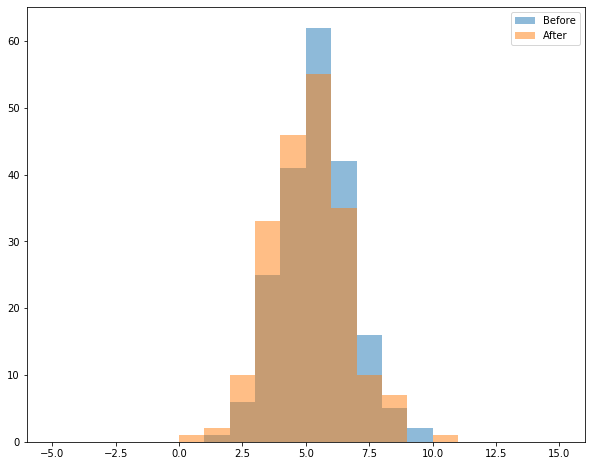

In [148]:
np.random.seed(seed=42)
datasæt1 = norm.rvs(loc=5.5, scale=1.5, size=200)
datasæt2 = norm.rvs(loc=5.0, scale=1.5, size=200)
fig, ax = plt.subplots()
hist1 = ax.hist(datasæt1, range=(-5,15), bins=20, alpha=0.5, label="Before")
hist2 = ax.hist(datasæt2, range=(-5,15), bins=20, alpha=0.5, label="After")
ax.legend()
ttest1 = ttest_ind(datasæt1, datasæt2, equal_var=False)
print(ttest1)
print("T-testen viser altså de to distrubitioner har forskellig middelværdi, med en p-værdi på 0.0318")

A) Gør det nemmere. Dette skyldes at den statistiske usikkerhed på middelværdien (og spredningen) bliver mindre.

Nedenstående celle viser et eksempel på dette.

Ttest_indResult(statistic=2.6695837442090484, pvalue=0.007801495026485082)
T-testen viser altså de to distrubitioner har forskellig middelværdi, med en p-værdi på 0.0078


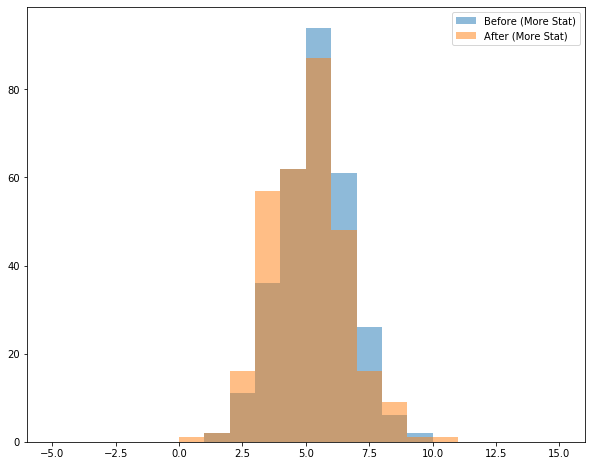

In [149]:
np.random.seed(seed=42)
datasæt1_morestat = np.concatenate([datasæt1, norm.rvs(loc=5.5, scale=1.5, size=100)])
datasæt2_morestat = np.concatenate([datasæt2, norm.rvs(loc=5.0, scale=1.5, size=100)])
fig, ax = plt.subplots()
_ = ax.hist(datasæt1_morestat, range=(-5,15), bins=20, alpha=0.5, label="Before (More Stat)")
_ = ax.hist(datasæt2_morestat, range=(-5,15), bins=20, alpha=0.5, label="After (More Stat)")
ax.legend()
ttest2 = ttest_ind(datasæt1_morestat, datasæt2_morestat, equal_var=False)
print(ttest2)
print("T-testen viser altså de to distrubitioner har forskellig middelværdi, med en p-værdi på 0.0078")

B) Gør det sværere. Dette skyldes at en højere intern varians i hvert sæt vil medføre en større spredning (altså en breddere distribution) og t-testens konklusion vil derfor være mindre signifikant.

Nedenstående celle viser et eksempel på dette.

Ttest_indResult(statistic=0.764643419618449, pvalue=0.44493856920862573)
T-testen viser altså at null hypotesen ikke kan forkastes, med en p-værdi på 0.4449


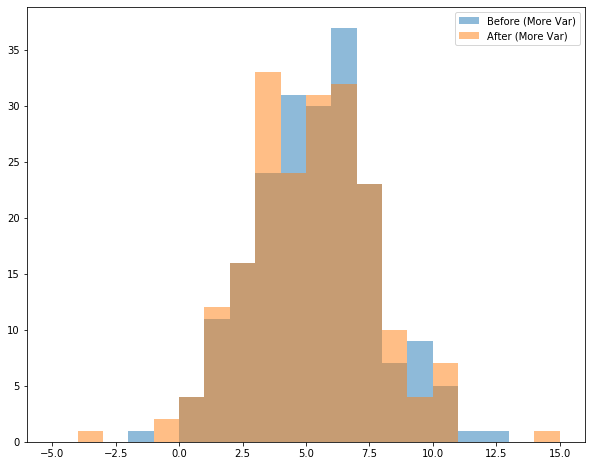

In [150]:
np.random.seed(seed=42)
datasæt1_morevar = norm.rvs(loc=5.5, scale=2.5, size=200)
datasæt2_morevar = norm.rvs(loc=5.0, scale=2.5, size=200)
fig, ax = plt.subplots()
_ = ax.hist(datasæt1_morevar, range=(-5,15), bins=20, alpha=0.5, label="Before (More Var)")
_ = ax.hist(datasæt2_morevar, range=(-5,15), bins=20, alpha=0.5, label="After (More Var)")
ax.legend()
ttest3 = ttest_ind(datasæt1_morevar, datasæt2_morevar, equal_var=False)
print(ttest3)
print("T-testen viser altså at null hypotesen ikke kan forkastes, med en p-værdi på 0.4449")

C) Gør det nemmere. Dette skyldes at selvom usikkerhederne på middelværdierne (og spredningen) ikke ændres bliver forskellen mere signifikant og derfor vil t-testens konklusion være mere signifikant.

Ttest_indResult(statistic=4.933861421886278, pvalue=1.188582065413836e-06)
T-testen viser altså de to distrubitioner har forskellig middelværdi, med en p-værdi på <0.0001


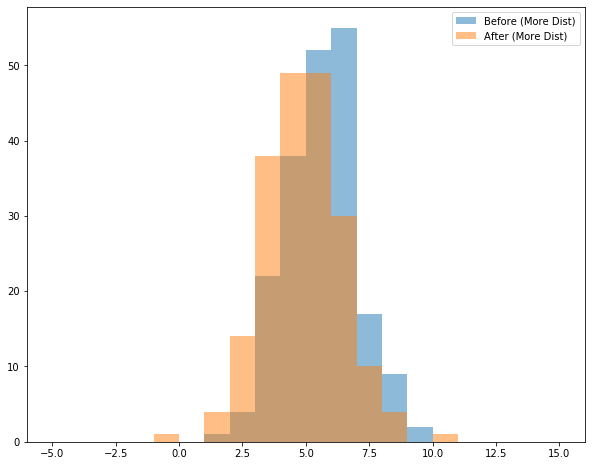

In [151]:
np.random.seed(seed=42)
datasæt1_moredist = norm.rvs(loc=5.7, scale=1.5, size=200)
datasæt2_moredist = norm.rvs(loc=4.8, scale=1.5, size=200)
fig, ax = plt.subplots()
_ = ax.hist(datasæt1_moredist, range=(-5,15), bins=20, alpha=0.5, label="Before (More Dist)")
_ = ax.hist(datasæt2_moredist, range=(-5,15), bins=20, alpha=0.5, label="After (More Dist)")
ax.legend()
ttest1 = ttest_ind(datasæt1_moredist, datasæt2_moredist, equal_var=False)
print(ttest1)
print("T-testen viser altså de to distrubitioner har forskellig middelværdi, med en p-værdi på <0.0001")

# Opgave 2

### 2.1 - Hvilke udfordringer ser du ved data? List alle de problemer som du kan finde i data.

### Hvad kan man gøre for at mitigere de kvalitetsmæssige problemer. Hvordan ville du rense data?

#### Svar:

Hvordan alle problemer blev fundet er forklaret nedenfor, men listen alle de fundne problemer er samlet her:
- 80 % af patienter har ingen "blood_pressure_systolic" måling
- 5 patienter har noteret en negativ alder
- 5 patienter har noteret en urealistisk vægt
- "height_cm" og "height_ft" er 100 % korrelerede og kun en af dem skal benyttes
- "weight_kg" er fejlagtigt blevet rundet af
- "BMI" er beregnet ud fra patientens vægt of højde og burde derfor ikke tilføje mere information

Det kan sagtens tænkes at andre værdier er enten urealistiske eller unødvendige, men da jeg ikke kender data bedre end jeg gør kan jeg ikke umiddelbart finde flere store problemer. I praksis vil jeg naturligvis forhøre mig hos en ekspert og sørge for at målingerne er korrekte.

For at mitigere de kvalitetsmæssige problemer vil jeg rense data på følgende måde:
- De 5 patienter med negativ alder bruges ikke
- "blood_pressure_systolic" bliver svært at bruge, men nogle algoritmer kan arbejde med manglede data (det testes, men ellers sættes til side)
- "height_ft" udelukkes
- Hvis jeg kan forsikre mig 100 %, hvordan BMI kolonnen er blevet til tænker jeg at omregne BMI til vægt i kg og vinde de ekstra 5 datapunkter tilbage. Er der nogen tvivl har jeg ikke specielt stor tiltro i præcisionen af BMI målingen, da jeg ikke har nogen præcis vægtmåling og vil nok spørge en mere erfaren kollega til råds

In [152]:
opg2data = pd.read_csv(ptf_Opgave2, delimiter=',', header=0)
opg2data

,age,weight_kg,height_cm,height_ft,cholesterol_total_mg_per_dl,BMI,blood_pressure_systolic,resting_heart_rate,VO2max
0,41,65,201.637448,6.615402,216,15.987147,NaN,432.531503,28.637225
1,19,70,174.390376,5.721469,214,23.017227,NaN,203.708074,20.231604
2,61,65,159.717567,5.240078,218,25.480502,NaN,234.704751,29.078526
3,14,70,156.600796,5.137821,206,28.543690,NaN,372.196590,36.314162
4,72,54,188.835298,6.195384,199,15.143540,NaN,308.293814,30.429989
...,...,...,...,...,...,...,...,...,...
995,87,64,187.131585,6.139488,211,18.276195,111.856708,360.247394,27.182971
996,24,71,162.527154,5.332256,231,26.878590,NaN,245.536236,20.319297
997,69,70,184.693975,6.059514,221,20.520720,101.092507,242.796742,20.662191
998,54,68,164.142600,5.385256,220,25.238660,NaN,390.144537,36.405437


Efter importering og et hurtigt kig på de første og sidste 5 række bliver første problem tydeligt, der fremgår NaNs i kollonen "blood_pressure_systolic", det skal undersøger nærmere. Men først lad os lige få en overblik over data, ved at lave histogrammer. 

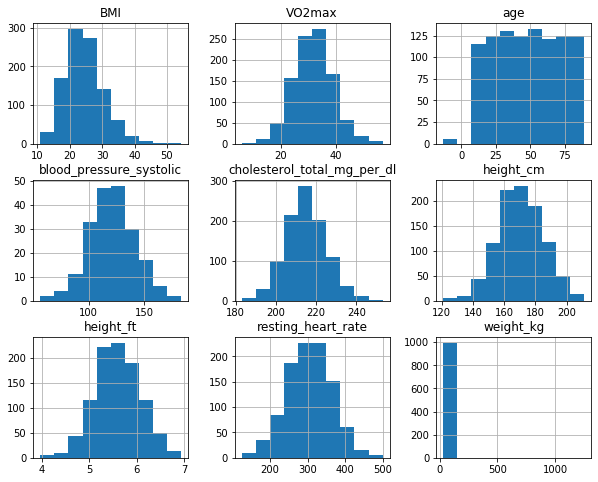

In [153]:
plt.rcParams['figure.figsize'] = [10,8]
opg2data_hist = opg2data.hist()

Histogrammerne fortæller os en række ting. Først af alt ser det umiddelbart ud til at meget data er godt og flere variabler fordeler sig sundt. Dog, er det tydeligt at se at der er mange NaNs i "blood_pressure_systolic" kolonnen, der er negative målinger i "age" kolonnen, og der er umiddelbart få meget høje målinger i "weight_kg" kolonnen. Jeg vil nu tjekke efter NaNs og negative værdier (da alle målinger burde være positive).

In [154]:
print("Searching for NaNs")
for column in opg2data.columns:
    print(f'#NaNs in {column} = {opg2data[column].isna().sum()}')

Searching for NaNs
#NaNs in age = 0
#NaNs in weight_kg = 0
#NaNs in height_cm = 0
#NaNs in height_ft = 0
#NaNs in cholesterol_total_mg_per_dl = 0
#NaNs in BMI = 0
#NaNs in blood_pressure_systolic = 800
#NaNs in resting_heart_rate = 0
#NaNs in VO2max = 0


80 % af patienterne har altså ingen måling af "blood_pressure_systolic".

In [155]:
print("Searching for Negative Measurements")
for column in opg2data.columns:
    print(f'#Negs in {column} = {opg2data[column].agg(lambda x: sum(x < 0))}')

Searching for Negative Measurements
#Negs in age = 5
#Negs in weight_kg = 0
#Negs in height_cm = 0
#Negs in height_ft = 0
#Negs in cholesterol_total_mg_per_dl = 0
#Negs in BMI = 0
#Negs in blood_pressure_systolic = 0
#Negs in resting_heart_rate = 0
#Negs in VO2max = 0


Det er altså blot 5 patienter, hvis alder er blevet noteret som varende negativ.

In [156]:
opg2data[opg2data["age"] < 0]

,age,weight_kg,height_cm,height_ft,cholesterol_total_mg_per_dl,BMI,blood_pressure_systolic,resting_heart_rate,VO2max
87,-11,74,167.934128,5.509650,228,26.239394,104.306908,289.231785,26.510923
97,-13,74,181.181572,5.944277,225,22.542583,NaN,315.876983,31.182484
644,-9,61,162.232027,5.322573,191,23.176969,NaN,229.203378,25.831703
739,-6,72,175.469925,5.756887,215,23.384448,118.006309,308.024834,32.209551
991,-10,69,175.291467,5.751032,208,22.455749,NaN,165.265428,26.679736


Der er ikke umiddelbart noget system i fejlen, det er i hvert fald usandsynligt at vægt/højde stemmer overens med alderes, skulle det havde været den samme type tastefejl.

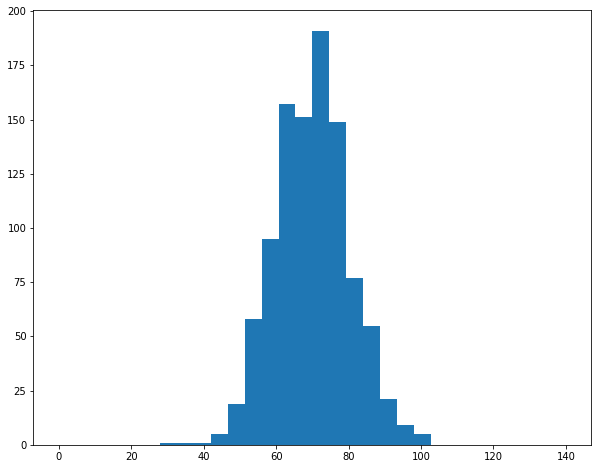

In [157]:
_ = plt.hist(opg2data["weight_kg"], range=(0,140), bins=30)

In [158]:
print(f'Antallet af patienter med urealistisk vægt = {np.sum(opg2data["weight_kg"] > 140)}')

Antallet af patienter med urealistisk vægt = 5


In [159]:
opg2data[opg2data["weight_kg"] > 140]

,age,weight_kg,height_cm,height_ft,cholesterol_total_mg_per_dl,BMI,blood_pressure_systolic,resting_heart_rate,VO2max
267,41,1043,183.831363,6.031213,211,22.785130,115.833141,261.288512,25.924240
291,54,1242,178.509638,5.856615,207,21.339566,128.962861,311.487268,44.429875
323,28,854,156.176810,5.123911,215,34.028672,NaN,369.816711,28.476536
544,53,1252,153.974443,5.051655,217,24.885979,NaN,258.840881,25.762856
571,24,1046,163.135879,5.352227,224,20.666347,NaN,305.336400,28.270119


Der er altså tale om 5 patienter, hvis vægt er noteret til at være meget urealistisk. Der fremgår igen ikke noget tydeligt mønster.

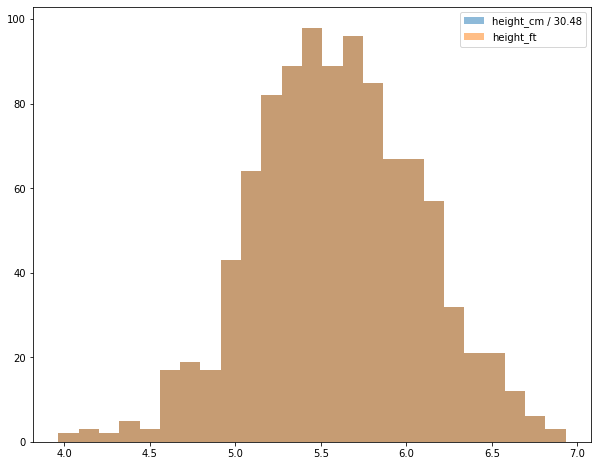

In [160]:
cm_in_feet = 30.48
_ = plt.hist(opg2data['height_cm'] / cm_in_feet, alpha=0.5, bins=25, label='height_cm / 30.48')
_ = plt.hist(opg2data['height_ft'], alpha=0.5, bins=25, label='height_ft')
_ = plt.legend()

Bare som sanity check sørgede jeg lige for at der var ikke noget underligt ved de to kolonner der beskriver højden af patienten. Disse to kolonner beskriver præcis den samme ting og er 100 % korrelerede og man burde derfor kun bruge én af værdierne.

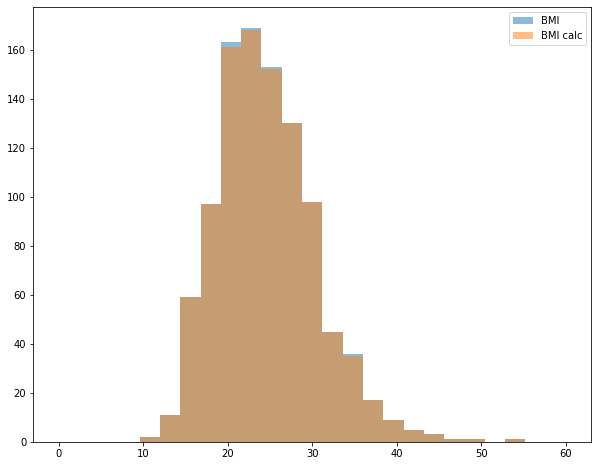

In [161]:
_ = plt.hist(opg2data['BMI'], alpha=0.5, range=(0,60), bins=25, label='BMI')
BMI_calc = opg2data['weight_kg'] / (opg2data['height_cm']/100)**2
_ = plt.hist(BMI_calc, alpha=0.5, range=(0,60), bins=25, label='BMI calc')
_ = plt.legend()

En BMI værdi udregnes ved følgende formel: vægt [kg] / højde [m]^2

Histogrammer ovenfor tyder på at dette er tilfældet. Det betyder at denne variable ikke bringer nogen yderliger information end vægt og højde allerede gør og burde derfor fjernes.

Den lille afvigelse imellem de to histogrammer skyldes højst sandsynligt at patienternes vægt er blevet rundet af til hele kilogram. Dette er højst besynderligt da alle andre målinger har mere end rigeligt betydelige ciffer.

Det er derfor vigtigt at vide om "BMI" kolonnen er udregnet før vægten blev rundet af. Hvis dette er tilfældet kan man enten vælge at bruge den samme omregning til at få en korrekt "weight_kg" kolonne, eller man kan blot give "BMI" kolonnen til algoritmen og lade den vinde den information gennem en lidt mere kompliceret sammenhæng. Det skal dog siges at omregner man BMI til vægt, vil man også vinde vægt målingen for de 5 patienter, hvis noterede vægt var urealistisk.

## 2.2 - Hvilke kolonner vil du beholder og hvilke vil du smide væk. Hvorfor?

### Svar:

Beholde:
- age
- height_cm
- cholesterol_total_mg_per_dl
- resting_heart_rate
- VO2max

Boblere:
- weight_kg
- BMI 

Smide væk:
- height_ft
- blood_pressure_systolic

Det meste af begrundelsen blev berørt i besvarelsen til opg. 2.1. En af boblerene skal bruges, og jeg vil gerne prøve at udnytte "blood_pressure_systolic"

## 2.3 - Hvordan kan denne præference tænkes ind i algoritme udviklingen?

### Svar:

Vi ønsker at vores algoritme yderst sjældent erklarer en syg patient for rask (FN), dette kan opnås ved forskellige værnemidler.

Man kan under træning vægte syge patienter højere raske patienter. Dette gøres ved at implementere såkaldte "sample weights", der straffer/belønner algoritmens ("loss functions") hårdere, når den korrekt erklare en syg patient for syg. Meget tilsvarende kan man også overpopulere den positive label, ved "oversampling", det burde meget den samme effekt.

Man kan vælge det "threshold", hvor algoritmen erklarer en person for syg, dette er altså en værdi mellem [0:1), således at man minimere falske negativer. Dette er naturligvis 0, og det vil i praktisk betyde at man giver alle patienter medicinen. Derfor kan man bruge ROC-curven til at vurdere en tilfredsstillende balance mellem FN og FP.

## 2.4 - Beskriv nogle forskellige præstationsmål for algoritmer som laver binar klassificering. Hvilke overvejelser skal man gøre sig ift. præstationsmål, hvis der er en meget skæv fordeling af de 2 kategorier?

### Svar:

I binær klassificering har man at gøre med 2 labels, hvilket jeg her vil refere til som signal (sande label 1) og baggrund (sande label 0). En ML algoritme leverer en score, et tal imellem 0 og 1, som repræsenterer hvor sikker algoritmen er på at målepunktet er enten signal (høj score, tæt på 1) eller baggrund (lav score, tæt på 0). Det er altså vores job at bestemme, hvornår vi stoler nok på algoritmens vurdering og derfor skal vi vælge en grænseværdi ("threshold"), hvor målepunkter med en score over denne værdi erklares for signal (label 1) og alt under erklares for baggrund (label 0). En række ting sker, når vi tager dette valg. For et givent målepunkt er der 4 mulige udfald:

- Sande label 1 og label 1 (True Positive, TP)
- Sande label 1 og label 0 (False Negative, FN)
- Sande label 0 og label 1 (False Positive, FP)
- Sande label 0 og label 0 (True Negative, TN)

Dette er grundstenen af det såkaldte confusion matrix, som indeholder en lang række værdier man kan beregne, som alle siger noget mere eller mindre brugbart om din algoritmes evne til at løse den binære klassificering. Jeg har altid synes at wiki siden er god og kompakt så den får lige et shout-out https://en.wikipedia.org/wiki/Confusion_matrix

Ud fra de fire introducerede udfald kan man beregne to størrelser, der beskriver hvor stor en procentdel af label 1 der erklæres korrekt og af label 0 der eklæres forkert.

- True Positive Rate  (TPR): TP / (TP + FN) = TP / P
- False Positive Rate (FPR): FP / (FP + TN) = TP / N

Hvor P og N refererer til antallet af hhv. label 1 og label 0.

Hvis man nu i stedet for at vælge én grænseværdi vælger en masse fordelt over intervallet (0,1) og plottede TPR mod FPR for alle punkterne vil have en Receiver Operating Characteristic (ROC) curve. Denne kurve giver et godt overblik over algoritmens evne til korrekt at erklære signal som funktion af dens evne til korrekt at erklære baggrund. Et brugbart præstationsmål for binær klassificering er arealet under denne ROC curve, også kallet AUC. En perfekt algoritme vil have AUC = 1. Denne giver os altså en enkeltstående værdi der indeholder en masse information til at evaluere vores algoritme.

Har man at gøre med en meget skæv fordeling af labels skal man være opmærksom på at ens præstationsmål tager højde for dette. For at give et konkret eksempel kan vi kigge på præstationsmålet accuracy, som ofte bruges til træning af algoritmer.

- Accuracy (ACC): (TP + TN) / (P + N)

In [162]:
P = 200
N = 9800
TP = 200*0.1
TN = 9800*0.95
print(f'ACC = {(TP + TN) / (P + N)}')

ACC = 0.933


Forestiller man sig en label-fordeling på 98% label 0 og 2% label 1 (kan sagtens være værre for bl.a. sjældne sygdomme). Rammer algoritmen 95% korrekt på label 0 og kun 10% korrekt på label 1 vil man få en accuracy på 0.933, hvilket ved første øjekast er et godt resultat. Men i virkeligheden er algoritmen meget dårlig til den del af opgaven der vejer mest.

# Opgave 3

## 3.1 - Kan du finde konkrete korrelationer mellem label værdierne? Ville opgaven kunne løses ved kun at lave én algoritme som forudsige én af label værdierne, hvorefter de andre labels kan udledes? I så fald, hvilket label skal forudsiges af en algoritme og hvilke kan derfra udledes?

### Svar:

Både label1 og label3 er strengt afgrænset i label2. Det er derfor muligt at forudsige både label1 og label3 ud fra en forudsigelse af label2. Der er altså tale om et regressionsproblem, hvorefter klassificering kan gøres ud fra disse simple grænser:

- Label1 = -1 for label 2 < 7.0
- Label1 = 1 for label 2 > 7.0


- Label3 = category_1 for label 2 < 5.14
- Label3 = category_2 for 5.14 < label 2 < 9.1745
- Label3 = category_3 for label2 > 9.1745

Besvarelsen er begrundet i det næste par celler.

In [163]:
opg3data = pd.read_csv(pft_Opgave3, delimiter=',', header=0)
opg3data

,col1,col2,col3,col4,label1,label2,label3
0,-104.260078,0.848727,4.359474,-0.462000,-1.0,5.965451,category_2
1,-112.768078,2.660304,2.731265,3.438523,-1.0,6.559512,category_2
2,-84.381122,2.542574,4.413660,15.445233,1.0,8.926347,category_2
3,-247.289486,0.225278,1.213606,6.655519,-1.0,6.501759,category_2
4,-74.440479,2.529568,6.447062,10.303060,1.0,9.294319,category_3
...,...,...,...,...,...,...,...
995,-236.265443,2.019755,5.282496,14.731949,1.0,12.630069,category_3
996,-225.515089,2.549566,3.621528,-1.424111,1.0,8.634920,category_2
997,-114.056046,1.132687,2.053329,6.809283,-1.0,5.718830,category_2
998,-118.319677,1.053378,4.245943,9.111677,1.0,7.567570,category_2


In [164]:
opg3data = opg3data.replace(to_replace=['category_1', 'category_2', 'category_3'], value=[1,2,3])

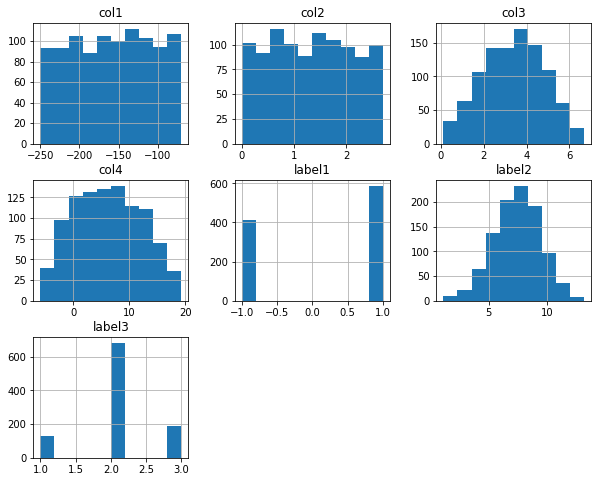

In [165]:
_ = opg3data.hist()

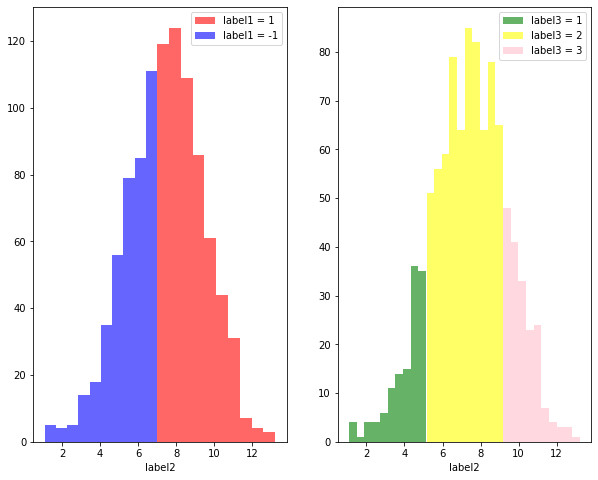

In [166]:
fig, ax = plt.subplots(1,2)

_ = ax[0].hist(opg3data[opg3data['label1'] == 1]['label2'], alpha = 0.6, label = 'label1 = 1', color='red')
_ = ax[0].hist(opg3data[opg3data['label1'] == -1]['label2'], alpha = 0.6, label = 'label1 = -1', color='blue')
_ = ax[0].legend()
_ = ax[0].set_xlabel('label2')
_ = ax[1].hist(opg3data[opg3data['label3'] == 1]['label2'], alpha = 0.6, label = 'label3 = 1', color='green')
_ = ax[1].hist(opg3data[opg3data['label3'] == 2]['label2'], alpha = 0.6, label = 'label3 = 2', color='yellow')
_ = ax[1].hist(opg3data[opg3data['label3'] == 3]['label2'], alpha = 0.6, label = 'label3 = 3', color='pink')
_ = ax[1].legend()
_ = ax[1].set_xlabel('label2')

In [167]:
print('Det venstre plot viser en klar seperation af label 2, som funktion af label 1')
print(f'Maximale værdi af blå hist: {max(opg3data[opg3data["label1"] == -1]["label2"])}')
print(f'Minimale værdi af rød hist: {min(opg3data[opg3data["label1"] == 1]["label2"])}')
print('Dette indikerer en skillegrænse omkring label2 = 7.0')
print('')
print('Det højre plot viser en klar seperation af label 2, som funktion af label 3')
print(f'Maximale værdi af grøn hist: {max(opg3data[opg3data["label3"] == 1]["label2"])}')
print(f'Minimale værdi af gul hist: {min(opg3data[opg3data["label3"] == 2]["label2"])}')
print(f'Maximale værdi af gul hist: {max(opg3data[opg3data["label3"] == 2]["label2"])}')
print(f'Minimale værdi af pink hist: {min(opg3data[opg3data["label3"] == 3]["label2"])}')
print('Dette indikerer to skillegrænser')
print('En mellem label3 = 1 og label3 = 2 omkring label2 = 5.14')
print('En anden mellem label3 = 2 og label3 = 3 omkring label2 = 9.1745')

Det venstre plot viser en klar seperation af label 2, som funktion af label 1
Maximale værdi af blå hist: 6.992006135708247
Minimale værdi af rød hist: 7.001815806841696
Dette indikerer en skillegrænse omkring label2 = 7.0

Det højre plot viser en klar seperation af label 2, som funktion af label 3
Maximale værdi af grøn hist: 5.127139363692658
Minimale værdi af gul hist: 5.160195153773334
Maximale værdi af gul hist: 9.171500204149654
Minimale værdi af pink hist: 9.175117337541957
Dette indikerer to skillegrænser
En mellem label3 = 1 og label3 = 2 omkring label2 = 5.14
En anden mellem label3 = 2 og label3 = 3 omkring label2 = 9.1745


## 3.2 - Hvilken type supervised learning ville egne sig til at forudsige den valgte label kolonne i forrige opgave og hvorfor?

## Hvilke mål for præsentation kan bruges for denne type algoritme? Nævn et par forskellige præstationsmål og beskriv hvordan de er forskellige.


### Svar:

Da label2 tilsyneladende antager uendeligt mange forskellige værdier er der altså tale om et regressions problem. Algoritmen har altså ikke til opgave at klassificere målepunkter, men nærmere at vurdere en værdi. Jeg nævnte tidligere at bruge ML algoritmer til at klassificere partikler i ATLAS detektoren, man kan ligeledes bruge dem til at vurdere deres energi, dette er dog et regressions problem.

I modsætning til binær klassificering, hvor vi havde fire mulige udfald for en given vurdering, kan vi i regression i stedet tale om, hvor forkert vores vurdering er. Vores præstationsmål skal altså sammenligne vores vurdering med den sande værdi og give os et mål på, hvor tæt på vi er.
Dette kan gøres på en række forskellige måder:

- Mean Squared Error (MSE): 1/n SUM(y - y_hat)^2
- Root Mean Squared Error (RMSE): sqrt( 1/n SUM(y - y_hat)^2 )
- Mean Absolute Error (MAE): 1/n SUM|y - y_hat|

Hvor SUM referer til en sum alle målepunkter, y referer til det sande label, og y_hat referer til algoritmens forudsigelse.

Disse præstationsmål har forskellige styrker og svagheder:

MSE er simpel, differentierbar, og da den sætter fejlen i anden bliver algoritmen straffet selv for små fejl.

RMSE forkuserer meget på store fejl og kan derfor være bedre til optimering. 

MAE er ret robust mod outliers, da den tager absolutværdien af fejlen.

## 3.3 - Hvilken fejl har du begået, og hvorfor er det en fejl?

### Svar:

Grunden til at man laver en opdeling af ens datasæt er udelukkende for at opnå den algoritme der generaliserer bedst til ny data. Modellens evne til at generaliseret er en direkte afspejling af hvor meget den har været i stand til at lære de udslagsgivende egenskaber ("features"), **uden** at lære de statistiske fluktuationer i træningssættet.
Det samme gør sig ligeledes gældende for testsættet, hvis man tester en masse forskellige modeller på dette sæt og vælger den bedste, har man højst sandsynligt fundet den algoritme der "overfitter" dette sæt. Det er derfor vigtigt at man sammenligner præstation på både trænings- og testsættet, når man vælger den algoritme der forventes at generelisere bedst til ny data. Ens præstationsmål burde gerne være høj og sammenlignelig i begge sæt.

## 3.4 - Træn en algoritme til at forudsige den valgte label. Hvor høj kan du præcisionen? Hvilket algoritme brugte du og hvorfor?

### Svar:

Jeg delte dataen op i 3 sæt, et trænings-, validerings-, og testsæt (80%/10%/10% fordeling). På test sættet fik jeg følgende præcision:
- MAE = 0.374
- MSE = 0.203

Da seed'et til lightgbm ikke helt virker, viser notebooken nok lidt anderledes resultater.

Jeg valgte at bruge en simpel træbaseret ensemble model, boosted decision trees, implementeret igennem LightGBM. Jeg gjorde dette fordi den er hurtig, simpel, og noget jeg kender. Desunden arbejder vi både med få variabler og en relativt lille mængde data, så simple modeller burde levere solide præstationer.

In [168]:
df_train, df_val, df_test = np.split(opg3data.sample(frac=1), [int(0.8*len(opg3data)), int(0.9*len(opg3data))])

X_train = df_train[['col1', 'col2', 'col3', 'col4']]
y_train = df_train['label2']

X_val = df_val[['col1', 'col2', 'col3', 'col4']]
y_val = df_val['label2']

X_test = df_test[['col1', 'col2', 'col3', 'col4']]
y_test = df_test['label2']

lgb_train = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
lgb_val = lgb_train.create_valid(X_val, label=y_val)

lgb_model = lgb.Booster(train_set = lgb_train)

Training until validation scores don't improve for 100 rounds
[25]	training's l2: 0.426324	valid_1's l2: 0.532167
[50]	training's l2: 0.0628099	valid_1's l2: 0.191664
[75]	training's l2: 0.0423328	valid_1's l2: 0.178256
[100]	training's l2: 0.0320437	valid_1's l2: 0.172788
[125]	training's l2: 0.0244822	valid_1's l2: 0.168686
[150]	training's l2: 0.0192794	valid_1's l2: 0.164573
[175]	training's l2: 0.0157828	valid_1's l2: 0.16401
[200]	training's l2: 0.012908	valid_1's l2: 0.162779
[225]	training's l2: 0.0106517	valid_1's l2: 0.161487
[250]	training's l2: 0.00890754	valid_1's l2: 0.160621
[275]	training's l2: 0.007497	valid_1's l2: 0.15974
[300]	training's l2: 0.00641495	valid_1's l2: 0.159059
[325]	training's l2: 0.00540892	valid_1's l2: 0.159052
[350]	training's l2: 0.00463128	valid_1's l2: 0.158654
[375]	training's l2: 0.00402456	valid_1's l2: 0.158647
[400]	training's l2: 0.00352279	valid_1's l2: 0.1587
[425]	training's l2: 0.00305916	valid_1's l2: 0.158124
[450]	training's l2: 0.

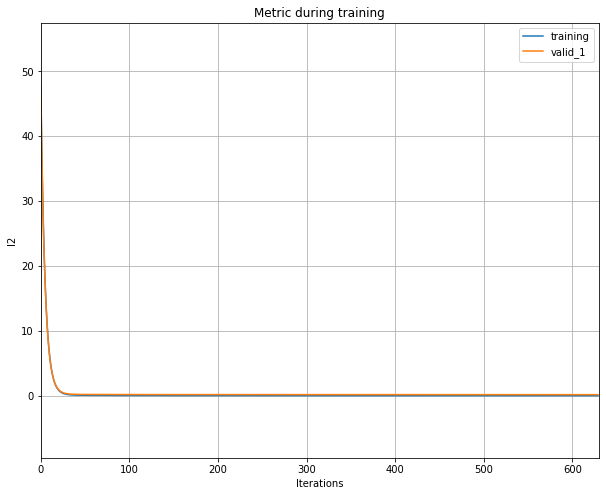

In [169]:
params = {'boosting_type': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'seed': 42, 
          'learning_rate': 0.1}

results = {}
lgb_model = lgb.train(params = params, 
                      train_set=lgb_train, 
                      init_model = lgb_model, 
                      valid_sets=[lgb_train, lgb_val], 
                      evals_result=results,
                      early_stopping_rounds=100,
                      num_boost_round = 2000,
                      verbose_eval = 25)
lgb.plot_metric(results)

In [170]:
def evaluering(X, y_true, name=''):
    preds = lgb_model.predict(X)
    print(f'{name} MAE: {mean_absolute_error(y_true, preds)}')
    print(f'{name} MSE: {mean_squared_error(y_true, preds)}')
    print(f'{name} R^2 score: {r2_score(y_true, preds)}')
    fig, ax = plt.subplots(1,2)
    _ = ax[0].hist(preds, alpha = 0.5, range=(1,13), bins=12, label='Prediction')
    _ = ax[0].hist(y_true, alpha = 0.5, range=(1,13), bins=12, label='True Label')
    _ = ax[0].legend(loc=2)
    _ = ax[0].set_xlabel('Label 2')
    _ = ax[0].set_ylabel('Count')
    
    _ = ax[1].scatter(preds, y_true)
    _ = ax[1].plot([0, 13], [0,13], color='black', label='Perfect Prediction')
    _ = ax[1].legend(loc=2)
    _ = ax[1].set_xlabel('Prediction')
    _ = ax[1].set_ylabel('True Label')

Evaluering på Træningssættet
Train MAE: 0.023248283103903457
Train MSE: 0.0017899877479506754
Train R^2 score: 0.9995412354170321


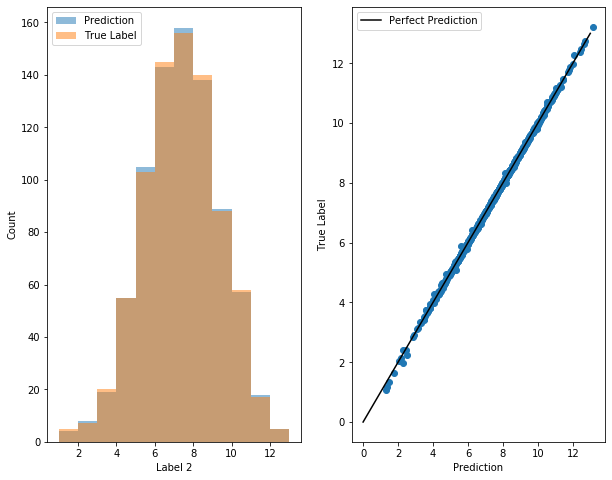

In [171]:
print(f'Evaluering på Træningssættet')
evaluering(X_train, y_train, name='Train')

Evaluering på Valideringssættet
Val MAE: 0.3233094796421716
Val MSE: 0.15777420995795935
Val R^2 score: 0.9601143099881513


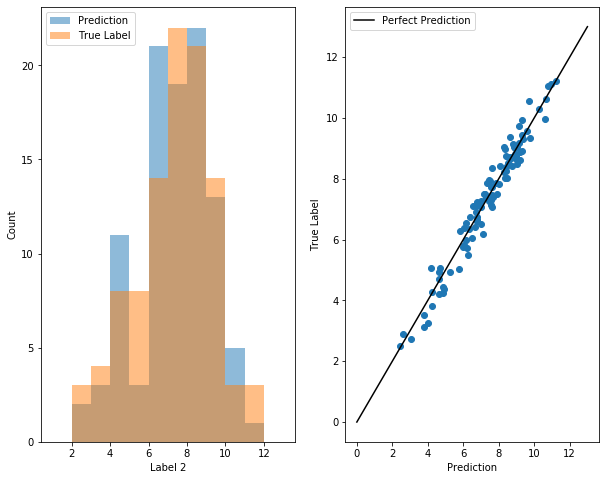

In [172]:
print(f'Evaluering på Valideringssættet')
evaluering(X_val, y_val, name='Val')

Evaluering på Testsættet
Test MAE: 0.3743899223072368
Test MSE: 0.20329557461541323
Test R^2 score: 0.956580288378513


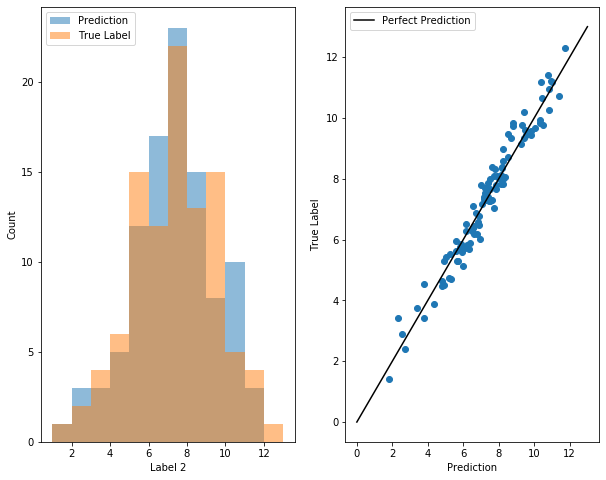

In [173]:
print(f'Evaluering på Testsættet')
evaluering(X_test, y_test, name='Test')

# Opgave 4

## 4.1 - Skriv noget kode som samler de 2 datasæt til ét, sådan at du kun beholder rækker hvor du både kender "cvr" og "t_type" værdierne.

### Svar:

Jeg har igen brugt pandas til at læse csv filerne og kan derfor udnytte pandas funktionen til nemt at løse opgaverne.
Denne opgave løses ved brug af pd.merge, som udgangspunkt merger den ved et 'inner' produkt, hvilket leverer det ønskede resultat. Det samlede datasæt hedder df_4_1

In [174]:
df1 = pd.read_csv(ptf_Opgave4_1, delimiter=',', header=0)
df2 = pd.read_csv(prf_Opgave4_2, delimiter=',', header=0)

In [175]:
df_4_1 = pd.merge(df1, df2)
df_4_1

,id,cvr,beloeb,t_type
0,0,95,3557,D
1,2,162,7096,D
2,7,59,9043,A
3,10,162,7228,C
4,11,15,3468,A
...,...,...,...,...
322,982,55,9670,E
323,985,72,5487,A
324,990,63,7055,E
325,991,86,1057,E


## 4.2 - Skriv noget kode som samler de 2 datasæt til ét, sådan at du beholder alle rækker hvor du bare kender mindst én af værdierne "cvr" eller "t_type".

### Svar:

Jeg bruger igen pd.merge, dog denne gang med metoden 'outer', som leverer det ønskede resultat. Det samlede datasæt hedder df_4_2

In [176]:
df_4_2 = pd.merge(df1, df2, 'outer')
df_4_2

,id,cvr,beloeb,t_type
0,0,95.0,3557.0,D
1,1,85.0,1842.0,NaN
2,2,162.0,7096.0,D
3,3,94.0,4276.0,NaN
4,4,173.0,5658.0,NaN
...,...,...,...,...
1668,2194,NaN,NaN,E
1669,2468,NaN,NaN,B
1670,1271,NaN,NaN,E
1671,2426,NaN,NaN,C


## 4.3 - Skriv noget kode som samler de 2 datasæt til ét, sådan at du beholder alle rækker hvor du kender præcis én af værdierne "cvr" eller "t_type", men ikke begge.

### Svar:

Jeg kunne ikke finde nogen ligeså elegant måde at løse denne opgave på, og måtte desværre nøjes med at fjerne de 'id' værdier der både har en "cvr" og "t_type" værdi fra den 'outer' mergede dataframe. Det samlede datasæt hedder df_4_3

In [177]:
ids_to_drop = pd.merge(df1, df2)['id']
df_4_3 = pd.merge(df1, df2, 'outer')
df_4_3 = df_4_3.drop(df3.loc[ids_to_drop].index, axis='index')
df_4_3

,id,cvr,beloeb,t_type
1,1,85.0,1842.0,NaN
3,3,94.0,4276.0,NaN
4,4,173.0,5658.0,NaN
5,5,179.0,7019.0,NaN
6,6,169.0,8267.0,NaN
...,...,...,...,...
1668,2194,NaN,NaN,E
1669,2468,NaN,NaN,B
1670,1271,NaN,NaN,E
1671,2426,NaN,NaN,C


## 4.4 - I denne opgave skal du tage udgangspunkt i det joinede datasæt du beregnede i første delopgave. Skriv noget kode som udregner det samlede beløb for hver virksomhed.

### Svar:

For at løse dette fandt jeg de unikke cvr numrer og lavede derfra en dataframe der indeholder en 'cvr', 'samlet_beloeb', og 't_types kolonne. Herfra kan man altså finde det samlede beløb en virksomhed har lavet transaktioner for ved at spørge df_4_4.loc[df_4_4['cvr'] == \*ønsket cvr\*, 'samlet_beloeb'].

In [178]:
unique_cvr = pd.Series.unique(df_4_1['cvr'])
virk_data = {'cvr':[], 'samlet_beloeb': [], 't_types': []}
for cvr in unique_cvr:
    virk_data['cvr'].append(cvr)
    virk_data['samlet_beloeb'].append(df_4_1.loc[df_4_1['cvr'] == cvr, 'beloeb'].sum())
    virk_data['t_types'].append(list(df_4_1.loc[df_4_1['cvr'] == cvr, 't_type']))

df_4_4 = pd.DataFrame(data=virk_data)

In [179]:
df_4_4

,cvr,samlet_beloeb,t_types
0,95,5034,"[D, B]"
1,162,26333,"[D, C, E, D]"
2,59,14486,"[A, A]"
3,15,3468,[A]
4,190,5514,[D]
...,...,...,...
158,83,4809,[A]
159,58,9765,[C]
160,146,9495,[B]
161,69,5097,[A]


In [180]:
df_4_4.loc[df_4_4['cvr'] == 146, 'samlet_beloeb']

160    9495
Name: samlet_beloeb, dtype: int64

## 4.5 - I denne opgave skal du tage udgangspunkt i det joinede datasæt du udregnede i første delopgave. Skriv noget kode som udregner en ny kolonne til datasættet. Kolonnen skal angive hvor sjælden den givne type transaktion er for en given virksomhed.

### Svar:

DataFramen fra sidste opgave er en stor hjælp i denne opgave, da jeg allerede har adgang til en liste over tranaktionstyper hver virksomhed har brugt. Det kan jeg bruge til at lave en encoding for hver virksomhed, t_type -> rarity. Denne encoding gemmes i et dict og kolonnen tilføjes til df_4_1 ved at loope over den eksisterende dataframe.

Jeg er lidt ærgerlig over at have brugt Pandas til opgave 4. At læse csv filer i python er lidt bøvlet, men kunne sagtens løses ved brug af en csv reader og lidt flere skridt. Men det er trods alt en af Pythons styrker, at jeg findes en masse pakker der kan en masse fede ting.

In [181]:
def fraction_of_t_types(lis):
    return {x: lis.count(x)/len(lis) for x in set(lis)}

In [182]:
t_type_fraction = {}
for cvr, t_types in zip(df_4_4['cvr'], df_4_4['t_types']):
    t_type_fraction[cvr] = fraction_of_t_types(t_types)

In [183]:
df_4_1['t_type_rarity'] = [t_type_fraction[x][y] for x, y in zip(df_4_1['cvr'], df_4_1['t_type'])]

In [184]:
df_4_1

,id,cvr,beloeb,t_type,t_type_rarity
0,0,95,3557,D,0.500000
1,2,162,7096,D,0.500000
2,7,59,9043,A,1.000000
3,10,162,7228,C,0.250000
4,11,15,3468,A,1.000000
...,...,...,...,...,...
322,982,55,9670,E,0.500000
323,985,72,5487,A,0.333333
324,990,63,7055,E,0.500000
325,991,86,1057,E,0.666667
